In [11]:
from train import valid, set_seed
from apex import amp
import torch
import argparse
from addict import Dict
import logging
import matplotlib.pyplot as plt
import logging
from utils.data_utils import get_loader
from models.modeling import VisionTransformer, CONFIGS
import numpy as np
from torch.utils.data import Subset
!export CUDA_VISIBLE_DEVICES=2
import torch.nn.functional as F

In [2]:
from utils.construct_tff import construct_real_tff, construct_tight_frames

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [5]:
args = Dict()
args.model_type = 'ViT-B_16'
args.dataset = 'inet1k_cats'
args.img_size = 224
args.pretrained_dir = 'checkpoint/ViT-B_16-224.npz'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
args.local_rank = -1
args.train_batch_size = 16
args.eval_batch_size = 16

# args.dataset = 'inet1k_cats'
# args.dataset_dir = 'data/inet1k_classes/cats'
# ckpt_path = 'output/inet1k_cats-2023-10-02-22-19-15/inet1k_cats_final_ckpt.bin' 
args.dataset = 'inet1k_birds'
args.dataset_dir = 'data/inet1k_classes/birds'
ckpt_path = 'output/inet1k_birds-2023-10-17-03-04-30/inet1k_birds_final_ckpt.bin'
# args.dataset = 'inet1k_dogs'
# args.dataset_dir = 'data/inet1k_classes/dogs'
# ckpt_path = 'output/inet1k_dogs-2023-09-24-21-00-17/inet1k_dogs_final_ckpt.bin'
# args.dataset = 'inet1k_snakes'
# args.dataset_dir = 'data/inet1k_classes/snakes'
# ckpt_path = 'output/inet1k_snakes-2023-10-02-22-28-06/inet1k_snakes_final_ckpt.bin'
# args.dataset = 'inet1k_trucks'
# args.dataset_dir = 'data/inet1k_classes/trucks'
# ckpt_path = 'output/inet1k_trucks-2023-09-24-20-47-28/inet1k_trucks_final_ckpt.bin'

In [6]:
# Prepare model
config = CONFIGS[args.model_type]

if args.dataset == "cifar10":
    num_classes = 10
elif args.dataset == "cifar100":
    num_classes = 100
elif 'inet' in args.dataset:
    num_classes = 10

model = VisionTransformer(config, args.img_size, zero_head=False, num_classes=num_classes)
# model.load_from(np.load(args.pretrained_dir))
model.load_state_dict(torch.load(ckpt_path))
model.to(args.device)
num_params = count_parameters(model)

logger.info("{}".format(config))
logger.info("Training parameters %s", args)
logger.info("Total Parameter: \t%2.1fM" % num_params)

2023-10-25 10:11:53,691 - __main__ - INFO - classifier: token
hidden_size: 768
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

2023-10-25 10:11:53,692 - __main__ - INFO - Training parameters {'model_type': 'ViT-B_16', 'dataset': 'inet1k_birds', 'img_size': 224, 'pretrained_dir': 'checkpoint/ViT-B_16-224.npz', 'device': device(type='cuda'), 'local_rank': -1, 'train_batch_size': 16, 'eval_batch_size': 16, 'dataset_dir': 'data/inet1k_classes/birds'}
2023-10-25 10:11:53,693 - __main__ - INFO - Total Parameter: 	85.8M


In [10]:
for name, param in model.named_parameters():
    if 'bias' in name:
        print(param)

Parameter containing:
tensor([-9.8457e-03,  1.1975e-02,  2.1200e-01,  3.1944e-02, -1.5844e-01,
         8.4247e-02,  1.3701e-01,  1.0480e-02,  1.1105e-01, -4.1281e-01,
        -1.0644e-02, -2.8039e-02,  1.1231e-03, -6.3426e-03, -5.3454e-02,
        -3.2657e-02,  1.0280e-02,  8.5739e-02,  4.1312e-03, -5.0202e-02,
        -7.1285e-02, -2.4642e-02,  1.0284e-02, -3.4300e-02, -1.6420e-02,
         1.1565e-02,  3.0742e-02, -2.7907e-02,  4.5575e-02, -2.1386e-02,
        -1.0681e-02, -1.1004e-02, -2.9740e-03, -4.9058e-03, -6.2680e-03,
        -7.6473e-03,  1.4537e-02, -3.3776e-02,  8.5325e-03,  9.7069e-03,
        -2.5428e-02,  4.1908e-02, -1.6918e-02, -1.8795e-02, -4.1767e-01,
         3.9766e-01,  2.9226e-03, -9.9355e-03,  1.0466e-01,  1.3912e-02,
         4.8664e-04,  4.1328e-01, -2.0019e-02, -2.0941e-02,  3.4421e-02,
        -6.2825e-04, -2.5718e-02, -1.8871e-03,  5.8121e-02, -1.5438e-01,
        -7.8089e-03,  2.9369e-02,  1.5667e-04,  1.1700e-02,  9.8537e-02,
         7.1684e-03,  8.1398e

In [7]:
train_loader, test_loader = get_loader(args)
classes = train_loader.dataset.dataset.classes

In [9]:
val_acc = valid(args, model, writer=None, test_loader=test_loader, global_step=0)
print(val_acc)

2023-10-24 12:59:42,160 - train - INFO - ***** Running Validation *****
2023-10-24 12:59:42,161 - train - INFO -   Num steps = 155
2023-10-24 12:59:42,162 - train - INFO -   Batch size = 16
Validating... (loss=0.00016): 100%|| 155/155 [00:10<00:00, 14.68it/s]
2023-10-24 12:59:52,744 - train - INFO - 

2023-10-24 12:59:52,745 - train - INFO - Validation Results
2023-10-24 12:59:52,746 - train - INFO - Global Steps: 0
2023-10-24 12:59:52,746 - train - INFO - Valid Loss: 0.01264
2023-10-24 12:59:52,746 - train - INFO - Valid Accuracy: 0.99758


0.9975796692214602


In [16]:
def quantize_qfna(x, scale, zero, maxq):
    q = torch.clamp(torch.round(x / scale) + zero, 0, maxq)
    return scale * (q - zero)

In [68]:
# Quantization bit
for looking_layer in [5]:
    # bits = [2,4,6,8,12,18,24,28, 32]
    # bits = [8,10,12]
    bits = [2]
    redundancies = [1,4,8,16,32]
    plt.figure()
    for redundancy in redundancies:
        mses = []
        compressions = []
        for bw in bits:
            maxq = torch.tensor(2**bw - 1)
            wmat = model.transformer.encoder.layer[looking_layer].attn.key.weight.data
            k_attn = int(96 * redundancy)
            l_attn = 8
            n_attn = 768
            print(f'redundancy = {k_attn*l_attn/n_attn}')
            tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
            projs = torch.matmul(tffs, wmat)
            # quantize the projs
            xmax = projs.max()
            xmin = projs.min()
            scale = (xmax - xmin) / maxq
            zero = torch.round(-xmin / scale)
            projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 
            mse = F.mse_loss(projs, projs_qntzd)
            mses.append(mse.item())

            compression = (32)//(bw*redundancy)
            compressions.append(compression)
            print(f'{bw = }, {mse = }, {redundancies = }')
        plt.semilogy(bits, mses)
    plt.legend([f'redundancy={i}x' for i in redundancies])
    plt.xlabel('number of bits')
    plt.ylabel('MSE')
    plt.title(f'layer {looking_layer}, MSE b/w the true weight, quantized weights')
    plt.grid()
    plt.savefig(f'./l{looking_layer}k')
    plt.close()

redundancy = 1.0
bw = 2, mse = tensor(0.0055, device='cuda:0'), redundancies = [1, 4, 8, 16, 32]
redundancy = 4.0
bw = 2, mse = tensor(0.0015, device='cuda:0'), redundancies = [1, 4, 8, 16, 32]
redundancy = 8.0
bw = 2, mse = tensor(0.0008, device='cuda:0'), redundancies = [1, 4, 8, 16, 32]
redundancy = 16.0
bw = 2, mse = tensor(0.0004, device='cuda:0'), redundancies = [1, 4, 8, 16, 32]
redundancy = 32.0
bw = 2, mse = tensor(0.0002, device='cuda:0'), redundancies = [1, 4, 8, 16, 32]


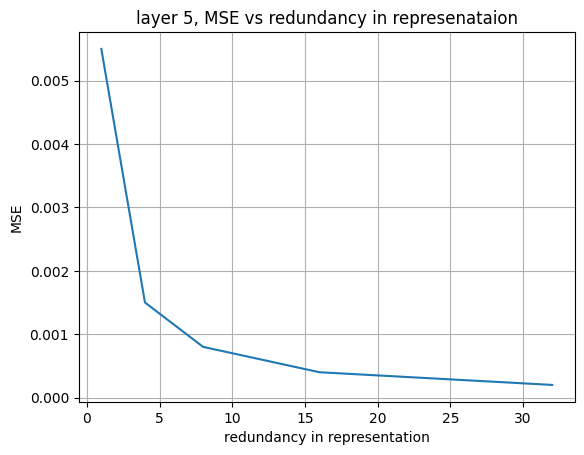

In [70]:
plt.plot(redundancies, [0.0055, 0.0015, 0.0008, 0.0004, 0.0002])
plt.xlabel('redundancy in representation')
plt.ylabel('MSE')
plt.grid()
plt.title('layer 5, MSE vs redundancy in represenataion')
plt.show()

In [33]:
print(mses)
print(bits)

[0.006349798757582903, 0.0005181358428671956, 1.7915814396474161e-06, 2.712095652224189e-11, 3.033359450598026e-16, 0.0016496508615091443, 0.00016906992823351175, 5.845006967319932e-07, 8.847185137272895e-12, 7.95504161129228e-17]
[2, 4, 8, 16, 32]


In [66]:
# for an MSE of 1e-7
bits = [8.5, 9, 9.5, 10, 11]
redus = [32, 16, 8,4,1]
compresss = [32/(b*r) for b,r in zip(bits, redus)]
print(compresss)

[0.11764705882352941, 0.2222222222222222, 0.42105263157894735, 0.8, 2.909090909090909]


redundancy = 32.0


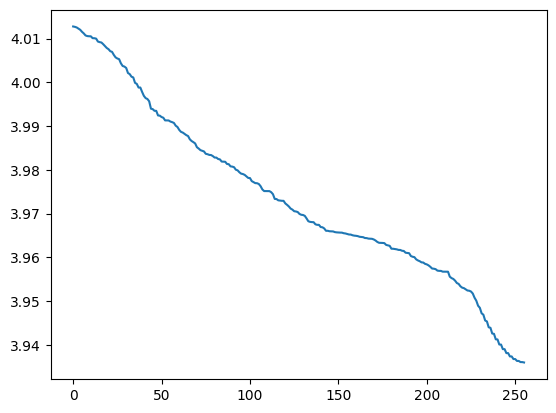

In [21]:
wmat = model.transformer.encoder.layer[5].attn.key.weight.data
k_attn = 256
l_attn = 96
n_attn = 768
print(f'redundancy = {k_attn*l_attn/n_attn}')
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
projs = torch.matmul(tffs, wmat)
norms = torch.norm(projs, dim=(1,2))
norms_sorted, _ = torch.sort(norms, descending=True)
plt.plot(norms_sorted.cpu())

redundancy = 32.0


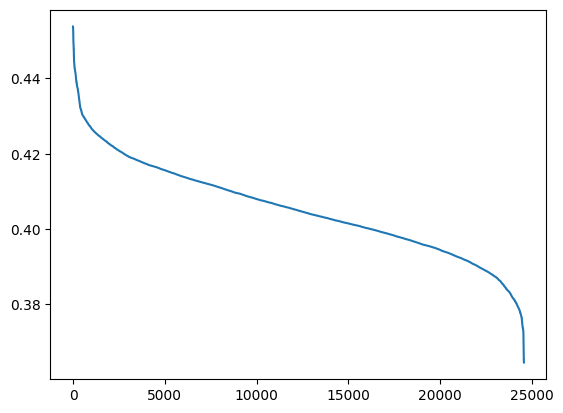

In [70]:
wmat = model.transformer.encoder.layer[5].attn.key.weight.data
k_attn = 768 * 32
l_attn = 1 
n_attn = 768
print(f'redundancy = {k_attn*l_attn/n_attn}')
tffs = construct_tight_frames(k_attn, l_attn, n_attn).to(args.device)
projs = torch.matmul(tffs, wmat.type(tffs.type()))
norms = torch.norm(projs, dim=(1,2))
norms_sorted, _ = torch.sort(norms, descending=True)
plt.plot(norms_sorted.cpu())

In [66]:
tffs.type()

'torch.cuda.ComplexFloatTensor'

In [24]:
k_attn = 256
l_attn = 96
n_attn = 768
print(f'redundancy = {k_attn*l_attn/n_attn}')
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
print(tffs.shape)
for i,t in enumerate(tffs):
    print(i)
    print(t)
    break

redundancy = 32.0
torch.Size([256, 96, 768])
0
tensor([[ 0.0625, -0.0000,  0.0625,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0625, -0.0015,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0031, -0.0625,  0.0015],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0624, -0.0015, -0.0625]],
       device='cuda:0')


In [61]:
tffs.shape

torch.Size([256, 96, 768])

In [24]:
for data, label in train_loader:
    data = data.to(device)
    out_logits, _ = model(data)
    print(out_logits)
    print(classes[label])
    break

tensor([[-0.3387,  0.5969, -0.5674,  ..., -0.3600,  0.3715, -0.2212],
        [ 0.6837,  0.0188,  0.0290,  ..., -0.1652,  0.0880, -0.1276],
        [ 0.8962, -0.6325,  0.3972,  ...,  0.4540, -0.1371, -0.3120],
        ...,
        [ 0.0443, -0.0582, -0.0945,  ...,  0.1240,  0.0954, -0.1654],
        [ 0.5564,  0.5776,  0.4610,  ...,  0.1824,  0.0287, -1.5507],
        [ 0.5302, -0.3743, -0.5047,  ..., -0.5446, -0.4084, -0.1608]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


TypeError: only integer tensors of a single element can be converted to an index

In [25]:
for i,j in zip(torch.amax(out_logits, dim=1).int(), label.detach()):
    print(i.item(), classes[j])

14 lorikeet
12 bald_eagle
15 prairie_chicken
13 vulture
13 African_grey
13 African_grey
13 lorikeet
14 hummingbird
12 vulture
7 bee_eater
15 coucal
13 lorikeet
11 bald_eagle
13 lorikeet
15 great_grey_owl
14 bald_eagle


In [2]:
rest= torch.load('output/inet1k_birds-frame_analysis-2023-10-17-04-50-59/results.pt')

In [3]:
print(rest.keys())

dict_keys(['k_attn', 'l_attn', 'n_attn', 'args', 'tffs_enabled_frames', 'tffs_disabled_frames', 'opt_res_dict', 'val_accs', 'avg_norm_ki', 'avg_rank_ki'])


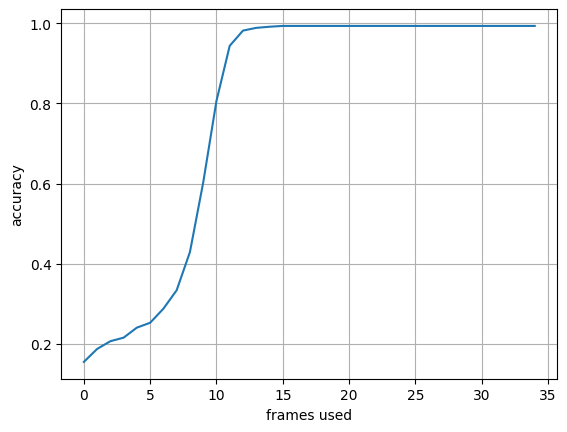

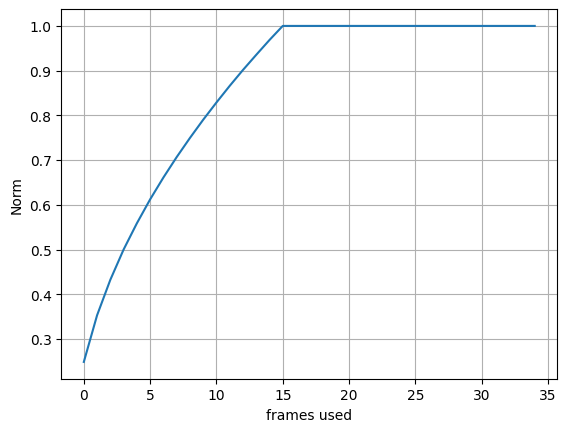

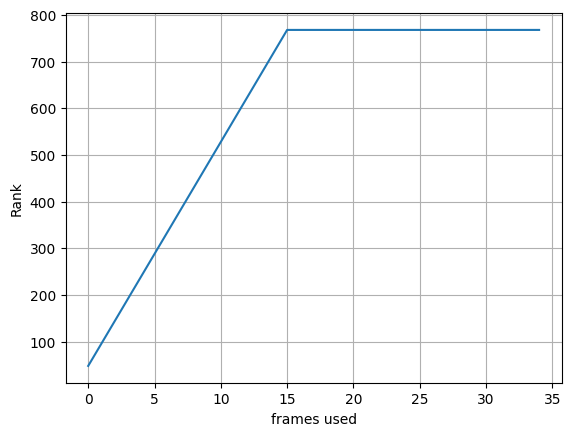

In [14]:
plt.plot(rest['opt_res_dict'].values())
plt.ylabel('accuracy')
plt.xlabel('frames used')
plt.grid()
plt.show()
plt.plot([i.item()/rest['avg_norm_ki'][-1].item() for i in rest['avg_norm_ki']])
plt.ylabel('Norm')
plt.xlabel('frames used')
plt.grid()
plt.show()
plt.plot([i.item() for i in rest['avg_rank_ki']])
plt.ylabel('Rank')
plt.xlabel('frames used')
plt.grid()
plt.show()

In [4]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print(resnet18)

Using cache found in /data/harsha/.cache/torch/hub/pytorch_vision_v0.10.0
/u/h/a/harshavardhan/miniconda3/envs/bnetff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/h/a/harshavardhan/miniconda3/envs/bnetff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  